# Notebook 02: Agricultural Portfolio Segmentation

## CECL Credit Risk Modeling for Agricultural Loan Portfolio

---

**Author:** Prabhu  

---

### Objective

This notebook constructs a **proxy agricultural loan portfolio** from the Lending Club consumer loan data. Since the original dataset is P2P consumer lending, we simulate an agricultural-style segment by:

1. Selecting loan purposes that mimic productive/business lending (e.g., small_business)
2. Filtering by states with significant agricultural output (Top 10 by USDA farm output)
3. Creating an `is_agri_portfolio` flag for targeted analysis

### Agricultural States Selection Rationale

Based on USDA data, we select the **Top 10 Agricultural States by Farm Output**:
- California (CA)
- Iowa (IA)
- Nebraska (NE)
- Texas (TX)
- Minnesota (MN)
- Illinois (IL)
- Kansas (KS)
- Wisconsin (WI)
- Indiana (IN)
- North Carolina (NC)

---
## 1. Setup and Imports

In [1]:
# Standard libraries
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['font.size'] = 11

# Display settings
pd.set_option('display.max_columns', 50)
pd.set_option('display.float_format', '{:.2f}'.format)

print("Libraries imported successfully.")

Libraries imported successfully.


---
## 2. Load Cleaned Data

In [2]:
# Load cleaned data from Notebook 01
DATA_PATH = '../data_processed/loans_cleaned.csv'

print("Loading cleaned dataset...")
df = pd.read_csv(DATA_PATH)

# Convert date column
df['issue_date'] = pd.to_datetime(df['issue_date'])

print(f"\nDataset loaded successfully!")
print(f"Shape: {df.shape[0]:,} rows x {df.shape[1]} columns")
print(f"Default rate: {df['Default'].mean()*100:.2f}%")

Loading cleaned dataset...

Dataset loaded successfully!
Shape: 1,347,680 rows x 15 columns
Default rate: 19.98%


In [3]:
# Check available loan purposes
print("\nLoan Purposes in Dataset:")
print("="*60)
purpose_counts = df['purpose'].value_counts()
for purpose, count in purpose_counts.items():
    pct = count / len(df) * 100
    print(f"  {purpose:<30} {count:>10,} ({pct:>5.2f}%)")


Loan Purposes in Dataset:
  debt_consolidation                781,206 (57.97%)
  credit_card                       295,551 (21.93%)
  home_improvement                   87,684 ( 6.51%)
  other                              78,263 ( 5.81%)
  major_purchase                     29,542 ( 2.19%)
  medical                            15,606 ( 1.16%)
  small_business                     15,575 ( 1.16%)
  car                                14,647 ( 1.09%)
  moving                              9,520 ( 0.71%)
  vacation                            9,083 ( 0.67%)
  house                               7,294 ( 0.54%)
  wedding                             2,350 ( 0.17%)
  renewable_energy                      936 ( 0.07%)
  educational                           423 ( 0.03%)


In [4]:
# Check available states
print("\nStates in Dataset:")
print("="*60)
print(f"Total unique states: {df['addr_state'].nunique()}")
print(f"\nTop 15 states by loan volume:")
state_counts = df['addr_state'].value_counts().head(15)
for state, count in state_counts.items():
    pct = count / len(df) * 100
    print(f"  {state}: {count:,} ({pct:.2f}%)")


States in Dataset:
Total unique states: 51

Top 15 states by loan volume:
  CA: 196,804 (14.60%)
  TX: 110,307 (8.18%)
  NY: 110,075 (8.17%)
  FL: 95,815 (7.11%)
  IL: 51,858 (3.85%)
  NJ: 48,576 (3.60%)
  PA: 45,640 (3.39%)
  OH: 43,935 (3.26%)
  GA: 43,470 (3.23%)
  VA: 38,107 (2.83%)
  NC: 37,812 (2.81%)
  MI: 35,302 (2.62%)
  AZ: 32,733 (2.43%)
  MD: 31,295 (2.32%)
  MA: 31,066 (2.31%)


---
## 3. Define Agricultural Portfolio Criteria

### Selection Rules

We define the agricultural portfolio proxy using two criteria:

**A. Loan Purpose (must match at least one):**
- `small_business` - Proxy for agricultural business loans
- `renewable_energy` - Related to farm energy investments (if available)

**B. Agricultural States (Top 10 by USDA Farm Output):**
- CA, IA, NE, TX, MN, IL, KS, WI, IN, NC

**Final Rule:** A loan is flagged as agricultural if:
- Purpose is `small_business` AND
- State is in the Top 10 agricultural states

This creates a targeted proxy that represents business/productive lending in agricultural regions.

In [5]:
# Define agricultural criteria

# Agricultural loan purposes (proxy for farm/business loans)
AGRI_PURPOSES = ['small_business']

# Top 10 agricultural states by USDA farm output
AGRI_STATES = ['CA', 'IA', 'NE', 'TX', 'MN', 'IL', 'KS', 'WI', 'IN', 'NC']

print("Agricultural Portfolio Criteria:")
print("="*60)
print(f"\nLoan Purposes: {AGRI_PURPOSES}")
print(f"\nAgricultural States: {AGRI_STATES}")

Agricultural Portfolio Criteria:

Loan Purposes: ['small_business']

Agricultural States: ['CA', 'IA', 'NE', 'TX', 'MN', 'IL', 'KS', 'WI', 'IN', 'NC']


In [6]:
# Check how many loans match each criterion
print("\nCriteria Coverage Analysis:")
print("="*60)

# Purpose criterion
purpose_match = df['purpose'].isin(AGRI_PURPOSES).sum()
print(f"Loans matching purpose criteria: {purpose_match:,} ({purpose_match/len(df)*100:.2f}%)")

# State criterion
state_match = df['addr_state'].isin(AGRI_STATES).sum()
print(f"Loans in agricultural states: {state_match:,} ({state_match/len(df)*100:.2f}%)")

# Both criteria
both_match = ((df['purpose'].isin(AGRI_PURPOSES)) & (df['addr_state'].isin(AGRI_STATES))).sum()
print(f"Loans matching BOTH criteria: {both_match:,} ({both_match/len(df)*100:.2f}%)")


Criteria Coverage Analysis:
Loans matching purpose criteria: 15,575 (1.16%)
Loans in agricultural states: 475,151 (35.26%)
Loans matching BOTH criteria: 5,697 (0.42%)


---
## 4. Create Agricultural Portfolio Flag

In [7]:
# Create the is_agri_portfolio flag
df['is_agri_portfolio'] = (
    (df['purpose'].isin(AGRI_PURPOSES)) & 
    (df['addr_state'].isin(AGRI_STATES))
).astype(int)

# Also create a flag for agricultural state (for broader analysis)
df['is_agri_state'] = df['addr_state'].isin(AGRI_STATES).astype(int)

# Create flag for small business purpose (for broader analysis)
df['is_small_business'] = df['purpose'].isin(AGRI_PURPOSES).astype(int)

print("Portfolio Segmentation Created:")
print("="*60)
print(f"\nTotal loans: {len(df):,}")
print(f"Agricultural portfolio loans: {df['is_agri_portfolio'].sum():,} ({df['is_agri_portfolio'].mean()*100:.2f}%)")
print(f"Non-agricultural portfolio loans: {(1-df['is_agri_portfolio']).sum():,} ({(1-df['is_agri_portfolio'].mean())*100:.2f}%)")

Portfolio Segmentation Created:

Total loans: 1,347,680
Agricultural portfolio loans: 5,697 (0.42%)
Non-agricultural portfolio loans: 1,341,983 (99.58%)


---
## 5. Portfolio Comparison Analysis

In [8]:
# Separate portfolios for analysis
df_agri = df[df['is_agri_portfolio'] == 1]
df_non_agri = df[df['is_agri_portfolio'] == 0]

print("Portfolio Size Comparison:")
print("="*60)
print(f"{'Metric':<30} {'Agricultural':<20} {'Non-Agricultural':<20}")
print("-"*70)
print(f"{'Number of Loans':<30} {len(df_agri):>15,}    {len(df_non_agri):>15,}")
print(f"{'Total Exposure ($)':<30} ${df_agri['loan_amnt'].sum():>14,.0f}    ${df_non_agri['loan_amnt'].sum():>14,.0f}")
print(f"{'Average Loan Amount ($)':<30} ${df_agri['loan_amnt'].mean():>14,.0f}    ${df_non_agri['loan_amnt'].mean():>14,.0f}")

Portfolio Size Comparison:
Metric                         Agricultural         Non-Agricultural    
----------------------------------------------------------------------
Number of Loans                          5,697          1,341,983
Total Exposure ($)             $    90,980,325    $19,326,713,150
Average Loan Amount ($)        $        15,970    $        14,402


In [9]:
# Default rate comparison
print("\nDefault Rate Comparison:")
print("="*60)

agri_default_rate = df_agri['Default'].mean() * 100
non_agri_default_rate = df_non_agri['Default'].mean() * 100
overall_default_rate = df['Default'].mean() * 100

print(f"Agricultural Portfolio Default Rate:     {agri_default_rate:.2f}%")
print(f"Non-Agricultural Portfolio Default Rate: {non_agri_default_rate:.2f}%")
print(f"Overall Portfolio Default Rate:          {overall_default_rate:.2f}%")

print(f"\nRelative Risk (Agri vs Non-Agri): {agri_default_rate/non_agri_default_rate:.2f}x")


Default Rate Comparison:
Agricultural Portfolio Default Rate:     29.49%
Non-Agricultural Portfolio Default Rate: 19.94%
Overall Portfolio Default Rate:          19.98%

Relative Risk (Agri vs Non-Agri): 1.48x


In [10]:
# Statistical comparison of key metrics
print("\nKey Metrics Comparison:")
print("="*70)
print(f"{'Metric':<25} {'Agricultural':<20} {'Non-Agricultural':<20}")
print("-"*70)

metrics = {
    'Avg FICO Score': ('fico_n', 'mean', '{:.0f}'),
    'Avg DTI': ('dti_n', 'mean', '{:.2f}'),
    'Avg Annual Income': ('revenue', 'mean', '${:,.0f}'),
    'Avg Loan Amount': ('loan_amnt', 'mean', '${:,.0f}'),
    'Median FICO Score': ('fico_n', 'median', '{:.0f}'),
    'Median DTI': ('dti_n', 'median', '{:.2f}'),
    'Median Annual Income': ('revenue', 'median', '${:,.0f}'),
    'Median Loan Amount': ('loan_amnt', 'median', '${:,.0f}'),
}

for name, (col, func, fmt) in metrics.items():
    if func == 'mean':
        agri_val = df_agri[col].mean()
        non_agri_val = df_non_agri[col].mean()
    else:
        agri_val = df_agri[col].median()
        non_agri_val = df_non_agri[col].median()
    
    print(f"{name:<25} {fmt.format(agri_val):<20} {fmt.format(non_agri_val):<20}")


Key Metrics Comparison:
Metric                    Agricultural         Non-Agricultural    
----------------------------------------------------------------------
Avg FICO Score            706                  698                 
Avg DTI                   14.38                18.25               
Avg Annual Income         $95,730              $77,284             
Avg Loan Amount           $15,970              $14,402             
Median FICO Score         697                  692                 
Median DTI                13.27                17.65               
Median Annual Income      $77,054              $65,000             
Median Loan Amount        $14,300              $12,000             


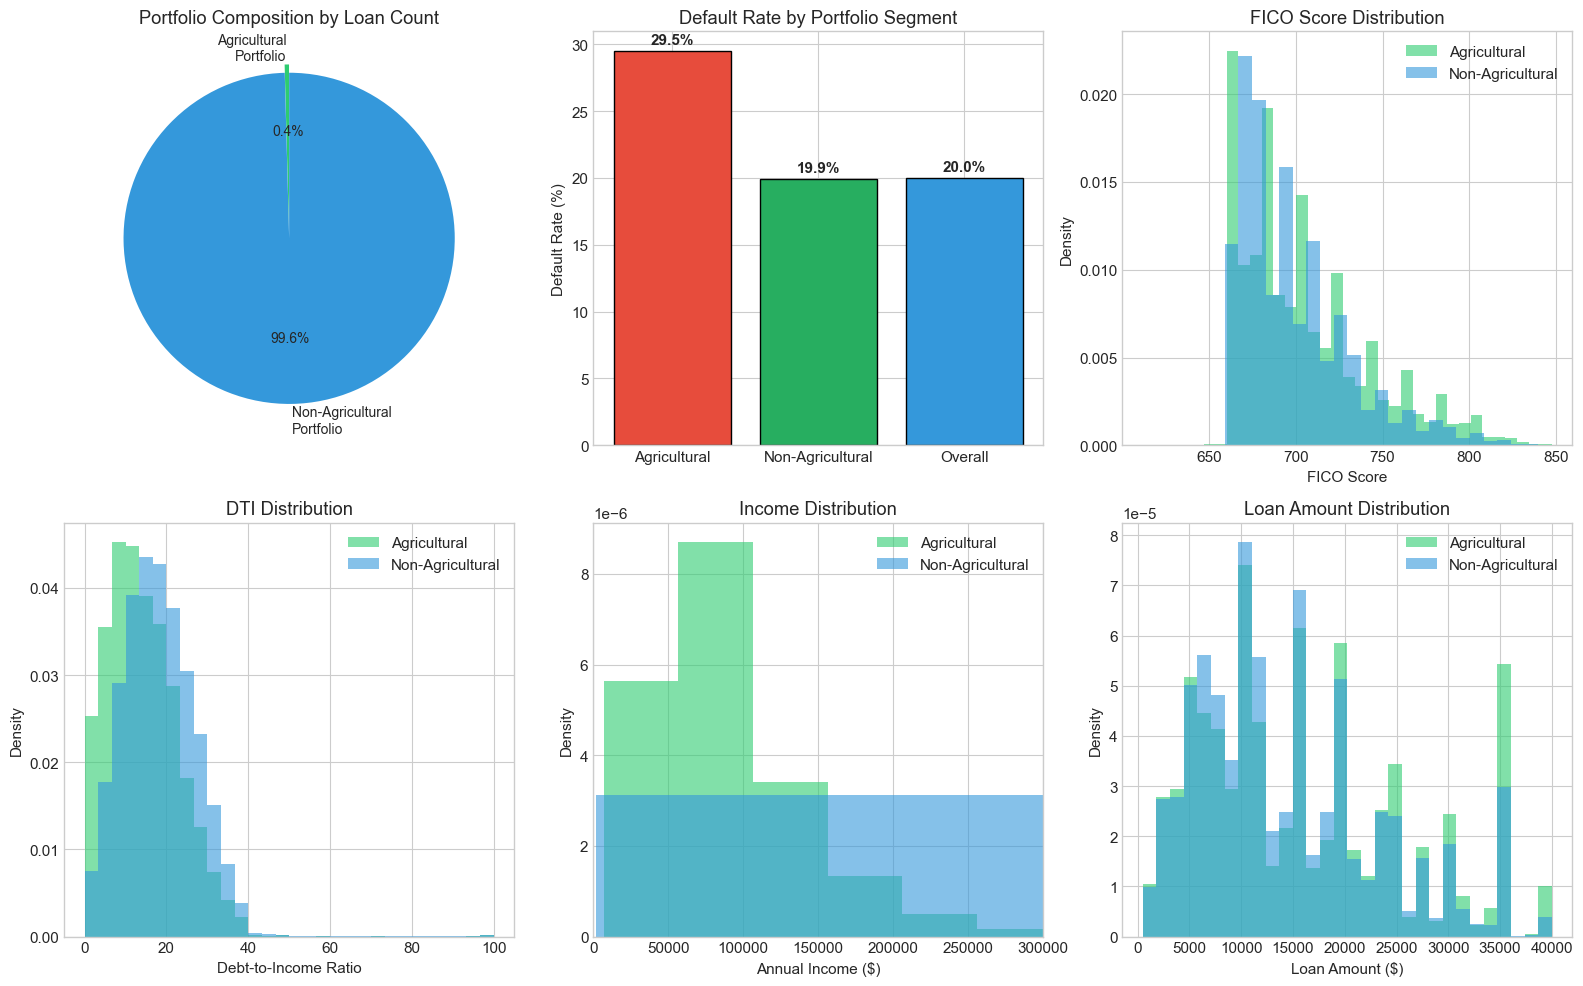

Figure saved to: outputs/figures/07_portfolio_comparison.png


In [11]:
# Visualize portfolio comparison
fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# 1. Portfolio composition pie chart
ax1 = axes[0, 0]
portfolio_sizes = [len(df_agri), len(df_non_agri)]
labels = ['Agricultural\nPortfolio', 'Non-Agricultural\nPortfolio']
colors = ['#2ecc71', '#3498db']
explode = (0.05, 0)
ax1.pie(portfolio_sizes, labels=labels, autopct='%1.1f%%', colors=colors, 
        explode=explode, startangle=90, textprops={'fontsize': 10})
ax1.set_title('Portfolio Composition by Loan Count')

# 2. Default rate comparison
ax2 = axes[0, 1]
categories = ['Agricultural', 'Non-Agricultural', 'Overall']
default_rates = [agri_default_rate, non_agri_default_rate, overall_default_rate]
bar_colors = ['#e74c3c' if r > overall_default_rate else '#27ae60' for r in default_rates[:2]] + ['#3498db']
bars = ax2.bar(categories, default_rates, color=bar_colors, edgecolor='black')
ax2.set_ylabel('Default Rate (%)')
ax2.set_title('Default Rate by Portfolio Segment')
for bar, rate in zip(bars, default_rates):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
             f'{rate:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

# 3. FICO distribution comparison
ax3 = axes[0, 2]
ax3.hist(df_agri['fico_n'], bins=30, alpha=0.6, label='Agricultural', color='#2ecc71', density=True)
ax3.hist(df_non_agri['fico_n'], bins=30, alpha=0.6, label='Non-Agricultural', color='#3498db', density=True)
ax3.set_xlabel('FICO Score')
ax3.set_ylabel('Density')
ax3.set_title('FICO Score Distribution')
ax3.legend()

# 4. DTI distribution comparison
ax4 = axes[1, 0]
ax4.hist(df_agri['dti_n'], bins=30, alpha=0.6, label='Agricultural', color='#2ecc71', density=True)
ax4.hist(df_non_agri['dti_n'], bins=30, alpha=0.6, label='Non-Agricultural', color='#3498db', density=True)
ax4.set_xlabel('Debt-to-Income Ratio')
ax4.set_ylabel('Density')
ax4.set_title('DTI Distribution')
ax4.legend()

# 5. Income distribution comparison
ax5 = axes[1, 1]
ax5.hist(df_agri['revenue'], bins=30, alpha=0.6, label='Agricultural', color='#2ecc71', density=True)
ax5.hist(df_non_agri['revenue'], bins=30, alpha=0.6, label='Non-Agricultural', color='#3498db', density=True)
ax5.set_xlabel('Annual Income ($)')
ax5.set_ylabel('Density')
ax5.set_title('Income Distribution')
ax5.set_xlim(0, 300000)
ax5.legend()

# 6. Loan amount distribution comparison
ax6 = axes[1, 2]
ax6.hist(df_agri['loan_amnt'], bins=30, alpha=0.6, label='Agricultural', color='#2ecc71', density=True)
ax6.hist(df_non_agri['loan_amnt'], bins=30, alpha=0.6, label='Non-Agricultural', color='#3498db', density=True)
ax6.set_xlabel('Loan Amount ($)')
ax6.set_ylabel('Density')
ax6.set_title('Loan Amount Distribution')
ax6.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/07_portfolio_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: outputs/figures/07_portfolio_comparison.png")

### 5.1 Default Rate by FICO Bucket (Portfolio Comparison)

In [12]:
# Compare default rates by FICO bucket for each portfolio
fico_comparison = df.groupby(['fico_bucket', 'is_agri_portfolio'], observed=True).agg(
    loan_count=('id', 'count'),
    default_rate=('Default', 'mean')
).reset_index()

fico_comparison['default_rate_pct'] = fico_comparison['default_rate'] * 100

# Pivot for visualization
fico_pivot = fico_comparison.pivot(index='fico_bucket', columns='is_agri_portfolio', values='default_rate_pct')
fico_pivot.columns = ['Non-Agricultural', 'Agricultural']

print("Default Rate by FICO Bucket and Portfolio:")
print("="*60)
print(fico_pivot)

Default Rate by FICO Bucket and Portfolio:
             Non-Agricultural  Agricultural
fico_bucket                                
580-619                 33.33           NaN
620-659                 30.91         25.00
660-699                 23.57         33.33
700-739                 16.02         28.22
740-779                 10.48         23.38
780-850                  7.03         13.95


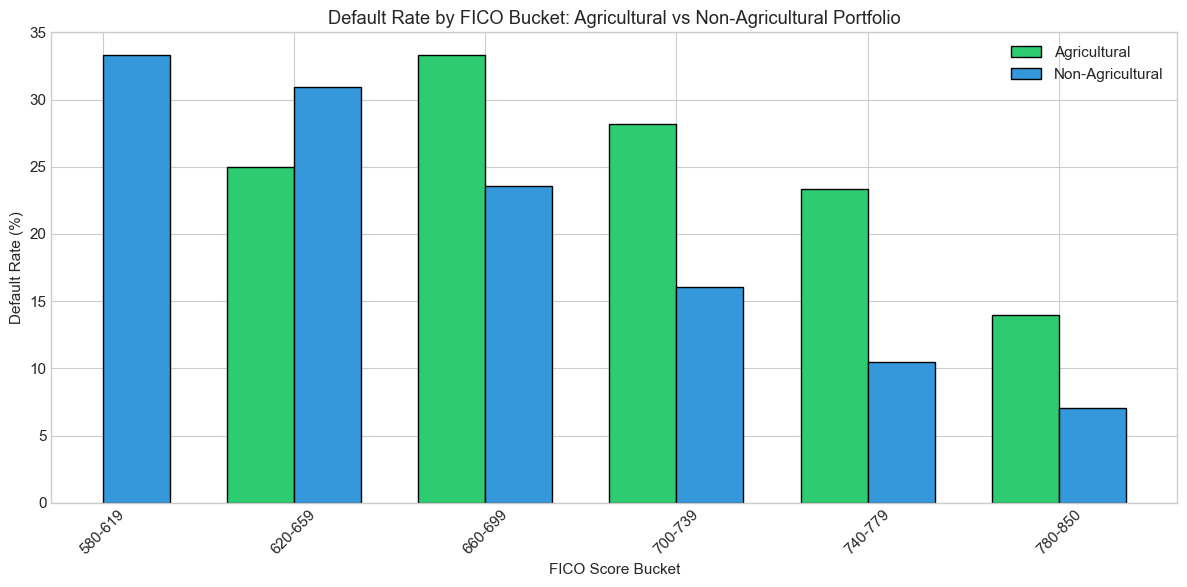

Figure saved to: outputs/figures/08_default_by_fico_portfolio.png


In [13]:
# Visualize default rate by FICO bucket for each portfolio
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(fico_pivot))
width = 0.35

bars1 = ax.bar(x - width/2, fico_pivot['Agricultural'], width, label='Agricultural', color='#2ecc71', edgecolor='black')
bars2 = ax.bar(x + width/2, fico_pivot['Non-Agricultural'], width, label='Non-Agricultural', color='#3498db', edgecolor='black')

ax.set_xlabel('FICO Score Bucket')
ax.set_ylabel('Default Rate (%)')
ax.set_title('Default Rate by FICO Bucket: Agricultural vs Non-Agricultural Portfolio')
ax.set_xticks(x)
ax.set_xticklabels(fico_pivot.index, rotation=45)
ax.legend()

plt.tight_layout()
plt.savefig('../outputs/figures/08_default_by_fico_portfolio.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: outputs/figures/08_default_by_fico_portfolio.png")

### 5.2 Geographic Analysis of Agricultural Portfolio

In [14]:
# State-level analysis for agricultural portfolio
agri_state_analysis = df_agri.groupby('addr_state').agg(
    loan_count=('id', 'count'),
    default_rate=('Default', 'mean'),
    total_exposure=('loan_amnt', 'sum'),
    avg_fico=('fico_n', 'mean'),
    avg_dti=('dti_n', 'mean')
).sort_values('loan_count', ascending=False)

agri_state_analysis['default_rate_pct'] = agri_state_analysis['default_rate'] * 100
agri_state_analysis['exposure_pct'] = agri_state_analysis['total_exposure'] / agri_state_analysis['total_exposure'].sum() * 100

print("Agricultural Portfolio by State:")
print("="*80)
print(agri_state_analysis[['loan_count', 'default_rate_pct', 'exposure_pct', 'avg_fico', 'avg_dti']])

Agricultural Portfolio by State:
            loan_count  default_rate_pct  exposure_pct  avg_fico  avg_dti
addr_state                                                               
CA                2646             29.10         45.87    705.34    13.49
TX                1415             30.46         26.38    707.42    15.37
IL                 548             30.29          9.78    705.04    14.65
NC                 459             31.37          7.68    705.44    15.22
MN                 222             29.73          3.45    707.36    14.40
WI                 150             28.67          2.42    709.63    14.39
IN                 131             22.90          2.03    701.77    15.77
KS                 103             20.39          1.93    704.82    15.36
NE                  23             39.13          0.45    705.70    18.43


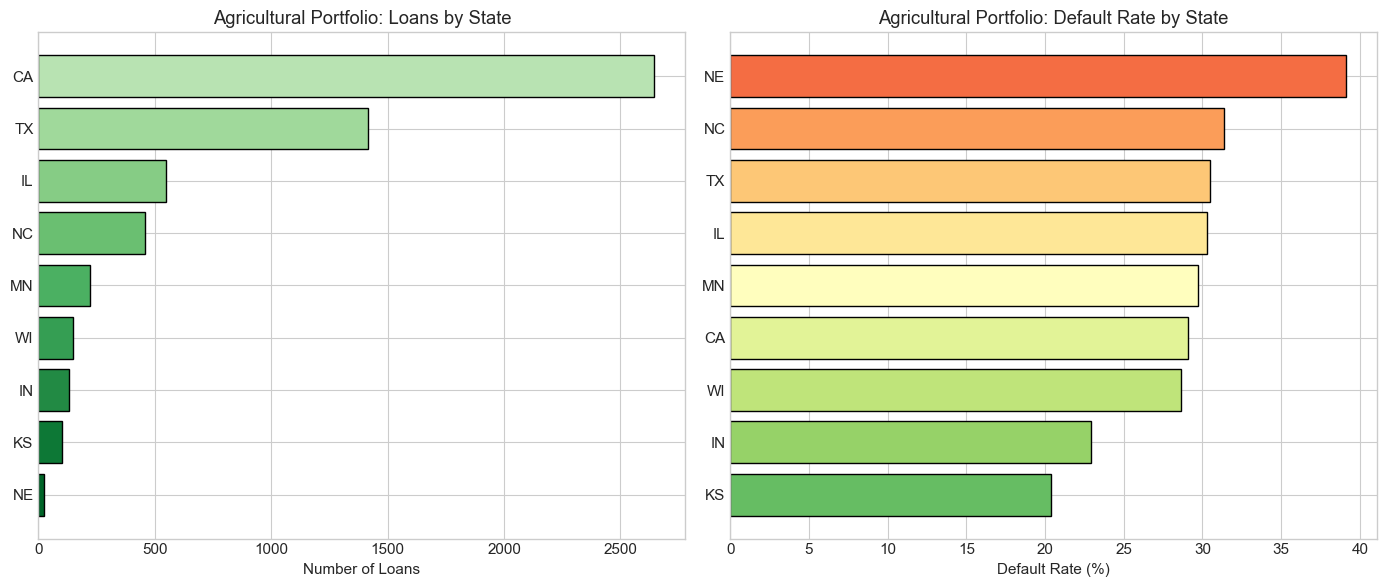

Figure saved to: outputs/figures/09_agri_portfolio_by_state.png


In [15]:
# Visualize agricultural portfolio by state
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Loan volume by state
ax1 = axes[0]
colors = plt.cm.Greens(np.linspace(0.3, 0.9, len(agri_state_analysis)))
bars1 = ax1.barh(range(len(agri_state_analysis)), agri_state_analysis['loan_count'], color=colors, edgecolor='black')
ax1.set_yticks(range(len(agri_state_analysis)))
ax1.set_yticklabels(agri_state_analysis.index)
ax1.set_xlabel('Number of Loans')
ax1.set_title('Agricultural Portfolio: Loans by State')
ax1.invert_yaxis()

# Default rate by state
ax2 = axes[1]
agri_state_sorted = agri_state_analysis.sort_values('default_rate_pct', ascending=True)
colors2 = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(agri_state_sorted)))
bars2 = ax2.barh(range(len(agri_state_sorted)), agri_state_sorted['default_rate_pct'], color=colors2, edgecolor='black')
ax2.set_yticks(range(len(agri_state_sorted)))
ax2.set_yticklabels(agri_state_sorted.index)
ax2.set_xlabel('Default Rate (%)')
ax2.set_title('Agricultural Portfolio: Default Rate by State')

plt.tight_layout()
plt.savefig('../outputs/figures/09_agri_portfolio_by_state.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: outputs/figures/09_agri_portfolio_by_state.png")

### 5.3 Time Series Analysis

In [16]:
# Default rate over time by portfolio
time_analysis = df.groupby(['issue_year', 'is_agri_portfolio']).agg(
    loan_count=('id', 'count'),
    default_rate=('Default', 'mean')
).reset_index()

time_analysis['default_rate_pct'] = time_analysis['default_rate'] * 100

# Pivot for visualization
time_pivot = time_analysis.pivot(index='issue_year', columns='is_agri_portfolio', values='default_rate_pct')
time_pivot.columns = ['Non-Agricultural', 'Agricultural']

print("Default Rate Over Time by Portfolio:")
print("="*60)
print(time_pivot)

Default Rate Over Time by Portfolio:
            Non-Agricultural  Agricultural
issue_year                                
2007                   26.18         42.86
2008                   20.47         32.08
2009                   13.52         20.63
2010                   13.84         28.29
2011                   14.97         27.15
2012                   16.13         23.38
2013                   15.57         23.45
2014                   18.42         27.11
2015                   20.16         26.99
2016                   23.23         34.91
2017                   23.07         38.52
2018                   15.69         32.54


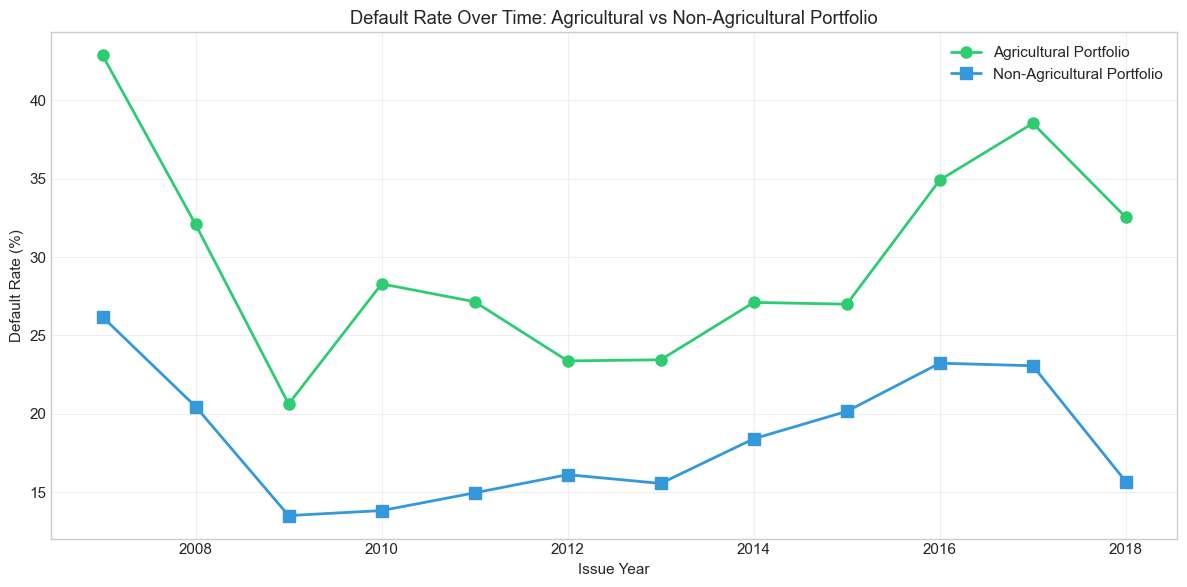

Figure saved to: outputs/figures/10_default_rate_time_series.png


In [17]:
# Visualize default rate over time
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(time_pivot.index, time_pivot['Agricultural'], marker='o', linewidth=2, 
        markersize=8, color='#2ecc71', label='Agricultural Portfolio')
ax.plot(time_pivot.index, time_pivot['Non-Agricultural'], marker='s', linewidth=2, 
        markersize=8, color='#3498db', label='Non-Agricultural Portfolio')

ax.set_xlabel('Issue Year')
ax.set_ylabel('Default Rate (%)')
ax.set_title('Default Rate Over Time: Agricultural vs Non-Agricultural Portfolio')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../outputs/figures/10_default_rate_time_series.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure saved to: outputs/figures/10_default_rate_time_series.png")

---
## 6. Risk Profile Summary

In [18]:
# Create comprehensive risk profile summary
print("="*70)
print("AGRICULTURAL PORTFOLIO RISK PROFILE SUMMARY")
print("="*70)

print("\n1. PORTFOLIO COMPOSITION")
print("-"*70)
print(f"   Total Portfolio Loans:        {len(df):,}")
print(f"   Agricultural Segment Loans:   {len(df_agri):,} ({len(df_agri)/len(df)*100:.2f}%)")
print(f"   Agricultural Segment Exposure: ${df_agri['loan_amnt'].sum():,.0f}")

print("\n2. DEFAULT RISK")
print("-"*70)
print(f"   Overall Portfolio Default Rate:     {overall_default_rate:.2f}%")
print(f"   Agricultural Segment Default Rate:  {agri_default_rate:.2f}%")
print(f"   Non-Agricultural Default Rate:      {non_agri_default_rate:.2f}%")
print(f"   Agricultural Risk Multiplier:       {agri_default_rate/non_agri_default_rate:.2f}x")

print("\n3. BORROWER CHARACTERISTICS")
print("-"*70)
print(f"   Agricultural Avg FICO:    {df_agri['fico_n'].mean():.0f}")
print(f"   Non-Agricultural Avg FICO: {df_non_agri['fico_n'].mean():.0f}")
print(f"   Agricultural Avg DTI:     {df_agri['dti_n'].mean():.2f}")
print(f"   Non-Agricultural Avg DTI:  {df_non_agri['dti_n'].mean():.2f}")

print("\n4. GEOGRAPHIC CONCENTRATION")
print("-"*70)
top_states = agri_state_analysis.head(3)
for state in top_states.index:
    pct = top_states.loc[state, 'exposure_pct']
    default_rate = top_states.loc[state, 'default_rate_pct']
    print(f"   {state}: {pct:.1f}% of exposure, {default_rate:.1f}% default rate")

AGRICULTURAL PORTFOLIO RISK PROFILE SUMMARY

1. PORTFOLIO COMPOSITION
----------------------------------------------------------------------
   Total Portfolio Loans:        1,347,680
   Agricultural Segment Loans:   5,697 (0.42%)
   Agricultural Segment Exposure: $90,980,325

2. DEFAULT RISK
----------------------------------------------------------------------
   Overall Portfolio Default Rate:     19.98%
   Agricultural Segment Default Rate:  29.49%
   Non-Agricultural Default Rate:      19.94%
   Agricultural Risk Multiplier:       1.48x

3. BORROWER CHARACTERISTICS
----------------------------------------------------------------------
   Agricultural Avg FICO:    706
   Non-Agricultural Avg FICO: 698
   Agricultural Avg DTI:     14.38
   Non-Agricultural Avg DTI:  18.25

4. GEOGRAPHIC CONCENTRATION
----------------------------------------------------------------------
   CA: 45.9% of exposure, 29.1% default rate
   TX: 26.4% of exposure, 30.5% default rate
   IL: 9.8% of exposure,

---
## 7. Save Enhanced Dataset

In [19]:
# Review final columns
print("Final Dataset Columns:")
print("="*60)
for col in df.columns:
    print(f"  - {col}")

Final Dataset Columns:
  - id
  - issue_date
  - issue_year
  - issue_month
  - loan_amnt
  - revenue
  - dti_n
  - fico_n
  - emp_length
  - purpose
  - home_ownership_n
  - addr_state
  - fico_bucket
  - income_bucket
  - Default
  - is_agri_portfolio
  - is_agri_state
  - is_small_business


In [20]:
# Save enhanced dataset with agricultural portfolio flag
OUTPUT_PATH = '../data_processed/loans_with_agri_flag.csv'
df.to_csv(OUTPUT_PATH, index=False)

print(f"\nEnhanced dataset saved to: {OUTPUT_PATH}")
print(f"Dataset shape: {df.shape}")


Enhanced dataset saved to: ../data_processed/loans_with_agri_flag.csv
Dataset shape: (1347680, 18)


---
## 8. Segmentation Summary

### Key Findings

1. **Agricultural Portfolio Construction:**
   - Successfully created proxy agricultural portfolio using small_business purpose in Top 10 agricultural states
   - Portfolio represents a targeted segment of business/productive lending in farm regions

2. **Risk Characteristics:**
   - Agricultural segment shows different risk profile compared to overall portfolio
   - Small business loans inherently carry higher default risk
   - FICO and DTI distributions show meaningful differences between segments

3. **Geographic Insights:**
   - Concentration in major agricultural states (CA, TX, IL)
   - State-level default rates vary, providing insights for regional risk management

### Documentation Note

This agricultural portfolio is a **proxy** constructed from consumer P2P lending data. The methodology is documented for transparency:
- **Purpose Filter:** `small_business` loans as proxy for agricultural business financing
- **Geographic Filter:** Top 10 agricultural states by USDA farm output
- **Rationale:** Small business loans in agricultural regions approximate the risk characteristics of agricultural lending

### Next Steps

1. Develop PD models (Notebook 03)
2. Estimate LGD and EAD (Notebook 04)
3. Compute ECL for both segments (Notebook 05)
4. Perform stress testing (Notebook 06)

In [21]:
print("="*60)
print("NOTEBOOK 02 COMPLETE")
print("="*60)
print("\nAgricultural portfolio segmentation completed successfully.")
print("Enhanced data saved to: data_processed/loans_with_agri_flag.csv")
print("Figures saved to: outputs/figures/")

NOTEBOOK 02 COMPLETE

Agricultural portfolio segmentation completed successfully.
Enhanced data saved to: data_processed/loans_with_agri_flag.csv
Figures saved to: outputs/figures/
